# Data Science in Practice: America's Favorite Quiz Show

A project by:
    - Ben Phan (A13034643)
    - Brandon Nguyen (A12725293)
    - Janet He (A13175632)

# Introduction and Background

Jeopardy! is one of the United States' longest running, general knowledge, trivia game shows. The show consists of the host, currently Alex Trebek, reading clues to contestants and the contestants have to guess what question the clue is the answer to. This is why all Jeopardy! answers are phrased in the form of a question.

There have been several contestants who have dominated the game using various tactics. One contestant, Ken Jennings, went on the longest Jeopardy! winning streak in the show's history. It was not just because Jennings had an encyclopedic mind with perfect recall, he also employed certain game theory tactics in order to maximize his daily winnings, which was how the winner was determined. At the end of the game, the player with the highest earnings wins, and moves on to the next day. Another player, Arthur Chu, became popular after going on a short winning streak using an unorthadox strategy with seemingly arbitrary wagers on the Daily Double questions. Chu also noted that there was a pattern: certain answers/clues would be more likely to appear in certain categories. 

The goal of this project is to determine whether or not there is an optimal strategy to preparing to be a contestant on Jeopardy!

This question is of particular interest to one of our group members, Brandon Nguyen, who was a former contestant of another game show and is an avid Jeopardy fan. During his time watching and follow Jeopardy, Brandon has noticed that some of the most successful Jeopardy players had very obvious strategies in order to go on massive winning streaks. After the successes of people such as Jennings and Chu, we would like to see if there is truth in their observations about the game.

Our goal is to find out which subjects a potential Jeopardy! contestant should study in order to maximize his or her performance on the game show. We are interested in whether trends in past Jeopardy! categories and answers could help guide a contestant's studying. We hypothesize that the frequencies of certain groups categories and answers will be significant enough to discern the best subjects to study when preparing for Jeopardy!. In order to test our hypothesis, we will categorize categories and answers by subject and examine the frequency, or number of occurrances of subjects by year.

To organize our analysis and discussion, we will define our list of subjects: Arts, Geography, History, Literature, Pop Culture, and Science.

# Data Description  


We will be using data from the Jeopardy Archives, which was consolidated by a Reddit user named trexmatt. Using a data scraper, trexmatt has compiled a CSV file containing over 200,000 observations which include: show numner, show air date, the round a question was asked, clue category, clue monetary value, the clue itself, and the answer (which would be phrased as a question). By analyzing this data, we hope to uncover any underlying patterns hidden away in the clues of the game.

To make our phrasing more intuitive, from now on, the clue will be referred to as the question.

The CSV file contains the question as a whole, and the answer column has the answer to the clue without the leading words that would make the phrasing a question. 


In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm

In [123]:
df = pd.read_csv('JEOPARDY_CSV.csv')

In [124]:
df.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [125]:
df.tail(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer
216925,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,$2000,This Puccini opera turns on the solution to 3 ...,Turandot
216926,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",$2000,In North America this term is properly applied...,a titmouse
216927,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,$2000,"In Penny Lane, where this ""Hellraiser"" grew up...",Clive Barker
216928,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,$2000,"From Ft. Sill, Okla. he made the plea, Arizona...",Geronimo
216929,4999,2006-05-11,Final Jeopardy!,HISTORIC NAMES,None,A silent movie title includes the last name of...,Grigori Alexandrovich Potemkin


# Data Cleaning and Pre-Processing
Before analyzing the data set, we need to do some data cleaning and pre-processing. Firstly, we decided to drop some of the columns that we will not be using in our analysis. The columns that we dropped are the Show Number and the Question columns. The columns that we cleaned up are the Air Dates, Value, and Answer columns. We did some processing on the Air Date column and extracted the year out of each observation, and in our cleaned up dataframe we renamed the Air Date column to year. For the Value column, we processed the money value by removing the dollar sign and commas, and we converted the type to be an integer. Additionally, we standardized each observation's money value by dividing by 2 for Double Jeopardy! questions. 

The Answer column proved to be the most difficult to clean. For this column, we cleaned each observation by removing quotes, parentheses and leading "a", "an", and "the" when appropriate. After removing those, we stripped the answers of any leading and trailing whitespace. Finally, we converted all the answers to lower case. Because we plan to analyze the uniqueness and frequency the answers, it is important to standardize the answers as best as possible. We cleaned the answers to the best of our ability, but it is not perfect. The messiness of the original answers makes it hard for us to clean the answers. For example, some of the answers with parentheses in them made it hard to tell which answers were the same as others. 

The following are some answers that will illustrate our problem:<br>
Ceylon (or Sri Lanka)<br>
Ceylon

In this case, we thought it would be best to completely remove the parentheses AND the content within them. Then, the answers would both be standardized to Ceylon. 

(Vladimir) Putin<br>
Vladimir Putin<br>

In this case, we only want to remove the parentheses, but keep the content within them. Then both answers would be standardized to Vladimir Putin.

Since the answers are so messy, we could not come up with a set of rules that would clean up and correctly standardize all the answers. In the end, we made the decision to only remove the parentheses. This helps in many cases, but it is not perfect.

In [126]:
# This method will be used to do some cleaning on the data: removing punctuation, parentheticals, leading articles,
# standardzing the letter case of the answers

def cleanAnswer(answer):
    answer = answer.replace('"', "")
    answer = answer.replace('(', "")
    answer = answer.replace(')', "")
    split = answer.split(' ', 1)
    firstWord = split[0]
    if len(split) == 2 and (firstWord == 'an' or firstWord == 'a' or firstWord == 'the'):
        answer = split[1]
    
    answer.strip()
    answer = answer.lower()
    return answer

In [127]:
# test clean method
print(cleanAnswer(' HELLO '), cleanAnswer('"A Streetcar Named Desire"'), cleanAnswer('the'), cleanAnswer('(Vladimir) Putin'))

 hello  a streetcar named desire the vladimir putin


In [128]:
# This method will take out the month/day of the show's air date. This helps us remove some of the privacy concerns
# as well as makes the data easier to work with

def cleanDate(date):
    return date[:4]

In [129]:
# This method will convert the monetary value of each question into an int type and remove leading dollar signs and
# any commas in the number

def convertValues(cost):
    if cost == "None":
        return 0
    cost = cost.replace("$", '')
    cost = cost.replace(',','')
    cost = int(cost)
    return cost

In [130]:
# This cell will apply the cleaning methods and then create a new dataframe with the cleaned data.

dfClean = pd.DataFrame()
#dfClean.columns = ['Year', 'Round', 'Category', 'Value', 'Answer']
dfClean['year'] = df[' Air Date'].apply(cleanDate)
dfClean['category'] = df[' Category']
dfClean['answer'] = df[' Answer'].apply(cleanAnswer)
dfClean = dfClean[dfClean['year'] != '2012']
display(dfClean)
dfClean.to_csv('jeopardyDFClean.csv')

,year,category,answer
0,2004,HISTORY,copernicus
1,2004,ESPN's TOP 10 ALL-TIME ATHLETES,jim thorpe
2,2004,EVERYBODY TALKS ABOUT IT...,arizona
3,2004,THE COMPANY LINE,mcdonald's
4,2004,EPITAPHS & TRIBUTES,john adams
5,2004,3-LETTER WORDS,ant
6,2004,HISTORY,appian way
7,2004,ESPN's TOP 10 ALL-TIME ATHLETES,michael jordan
8,2004,EVERYBODY TALKS ABOUT IT...,washington
9,2004,THE COMPANY LINE,crate & barrel


# Data Visualization

In order to put our hypothesis to the test, we want to find out which categories and answers are the most common, as those would be good subjects to study in prepartion of competing on Jeopardy!. 

To get a sense of how the most common answers and categories vary (or not) in frequency over time, we will create two heat maps. The first will be a graph with answers on the y axis and year on the x axis. The second will be a graph with categories on the y axis and year on the x axis. Both graphs will be colored based on how many times the answer or category appeared in a given year.

In [131]:
observationsByYear = dfClean['year'].value_counts()

In [132]:
minYear = int(dfClean['year'].min())
maxYear = int(dfClean['year'].max())

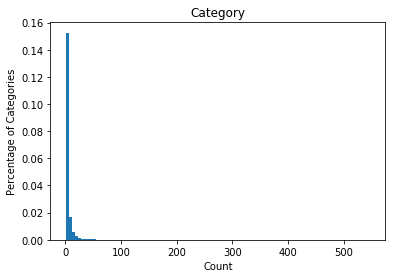

In [160]:
# Figure 1
# A histogram showing the percantage of the total number of categories that have a certain number of questions

allCatCounts = dfClean['category'].value_counts()
fig1 = plt.gcf()
plt.title('Category')
plt.ylabel('Percentage of Categories')
plt.xlabel('Count')
plt.hist(allCatCounts, normed=True, bins=100)
plt.show()

On the x-axis of this histogram is the number of of questions that have appeared in a category, and on the y-axis is the percentage of the total number of categories that have had that many questions in them. From the figure, one can see that most categories have fewer than 50 questions in them over the span of our data set. This means that the categories are fairly diverse and many questions do not come from a single category. The graph shows that about 15% of categories only have about 5 questions, which means that, that category has likely only appeared once in all of Jeopardy. This shows that Jeopardy has a diverse set of categories to pull from for all their games.


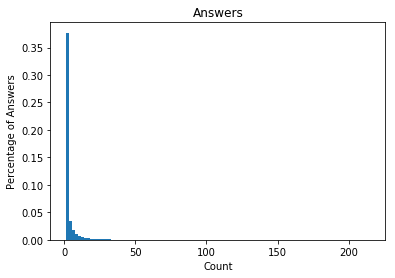

In [159]:
# Figure 2
# This histogram shows the percentage of the total number of answers that have appeared a certain amount of times

allAnswerCounts = dfClean['answer'].value_counts()
fig2 = plt.gcf()
plt.title('Answers')
plt.ylabel('Percentage of Answers')
plt.xlabel('Count')
plt.hist(allAnswerCounts, normed=True, bins=100)
plt.show()

On the x-axis of this histogram is the number of times an answer has appeared on Jeopardy!, and on the y-axis is the percentage of the total number of answers that have had that many appearances. The graph shows a similar finding to figure 1, in that most answers appear less than 25 times across any category during any game of Jeopardy! This shows a strong diversity of answers to the Jeopardy! questions as well.


Both figures 1 and 2 show an incredibly skewed graph. This shows that both the categories and answers are diverse in Jeopardy! There are only a few categories appear more than 1 or twice. Something similar can be said of the answers as wel. More than 35% of the answers appear less than 10 times. Our data set contains over 200,000 questions, meaning that if most appear less than 10 times, there is a very sizeable spread of questions being asked throughout Jeopardy!


In [135]:
catTop = dfClean['category'].value_counts()[:50]

In [136]:
cats = []

for year in range(minYear, maxYear+1):
    yearCats = dfClean[dfClean['year']==str(year)]
    countsInYear = []
    for i in range(0, len(catTop)):
        cat = yearCats[yearCats['category']==catTop.index[i]]
        countsInYear.append(len(cat)/float(observationsByYear[str(year)]))
    
    cats.append(countsInYear)
    
cats = np.transpose(cats)

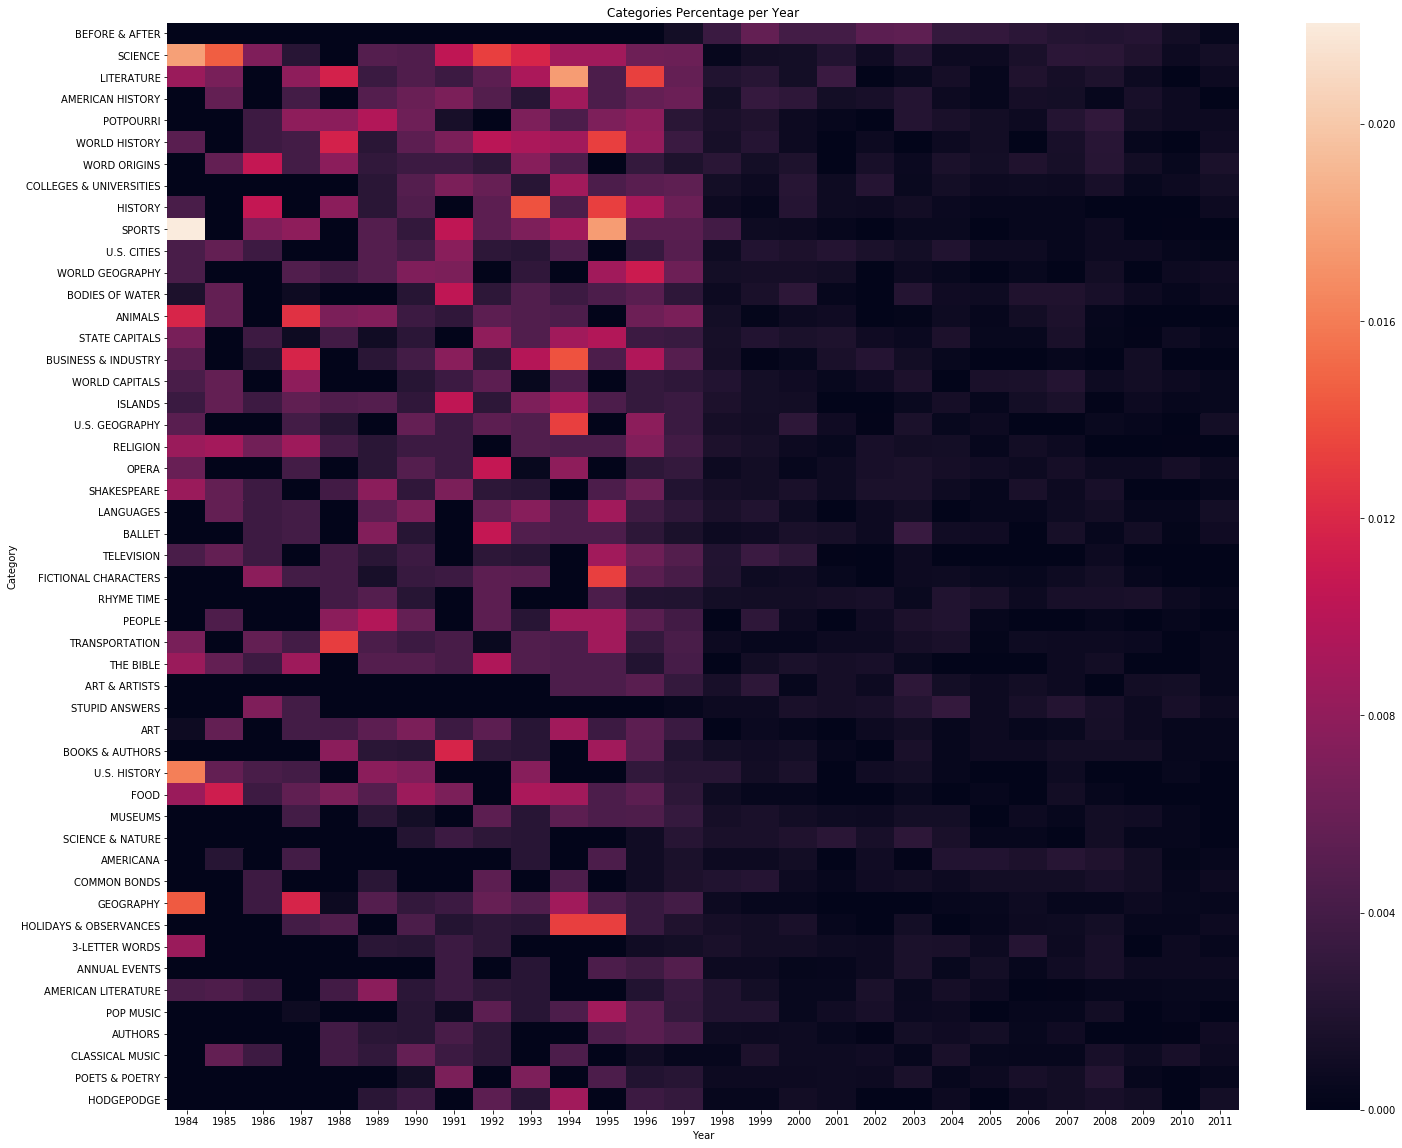

In [137]:
# Figure 3
# A heatmap showing the percentage of how often a category appeared in Jeopardy! by year.

plt.figure(figsize=(24,20))
catsHeat = sns.heatmap(cats, annot=False, fmt="d")

catsHeat.set_xticklabels(range(minYear, maxYear + 1))
catsHeat.set_yticklabels(catTop.index, rotation=0)
catsHeat.set_xlabel('Year')
catsHeat.set_ylabel('Category')
catsHeat.set_title('Categories Percentage per Year')
plt.show()

This heatmap shows how often each of the top 50 categories appeared in every year. The top 50 category designation means that these 50 categories have had the most questions asked (from the category) during the entirety of our data set. The heatmap shows that there has been a good spread of question being asked every year with no consistent category being asked too often. Another interesting observation from this visualization is that there is a drastic change after the year 1997. After 1997, it shows that the appearances of the top 50 overall categories decreases greatly. We are unsure exactly of what caused this change, but we propose that between the 97-98 season, Jeopardy! added more question writers which resulted in a large influx of new questions and categories.


In [138]:
answerTop = dfClean['answer'].value_counts()[:50]

In [139]:
answers = []

for year in range(minYear, maxYear + 1):
    yearAnswers = dfClean[dfClean['year']==str(year)]
    answerCountsInYear = []
    for i in range(0, len(answerTop)):
        answer = yearAnswers[yearAnswers['answer']==answerTop.index[i]]
        answerCountsInYear.append(len(answer)/observationsByYear[str(year)])
    
    answers.append(answerCountsInYear)
    
answers = np.transpose(answers)

In [1]:
# Figure 4
# This heatmap shows the percentage of how often an answer appeared in Jeopardy! by year

plt.figure(figsize=(24,20))
answersHeat = sns.heatmap(answers, annot=False, fmt="d")

answersHeat.set_xticklabels(range(minYear, maxYear + 1))
answersHeat.set_yticklabels(answerTop.index, rotation=0)
answersHeat.set_xlabel('Year')
answersHeat.set_ylabel('Answer')
answersHeat.set_title('Answers Percentage per Year')
plt.show()

NameError: name 'plt' is not defined

This heatmap shows how often one of the top 50 answers have appeared in a given year. We see similar results from the prior heatmap in that there are no answers that have strong repeated us year after year. This again shows a strong diversity in answers to Jeopardy! questions. We also see that sudden change in the trends of answers around 1997. If our proposed theory that Jeopardy! Added new question writers, that would also explain why the top 50 answers are not as common as they would have been in previous years. If there are more new questions, then chances are, there would be more new answers, which would reduce the percentage of each top 50 answer.


# Data Analysis and Results

## Assigning Subjects to Categories

We can further analyze the data by categorizing similar categories into subjects. It is not feasible to categorize every single category, so we are using the top 50 most frequent categories to make our categorizations. We manually categorized each category by subject. Eventually, we came up with a list of six encompassing subjects: arts, history, geography, literature, pop culture, and science. For every observation whose category is in the top 50 categories, we assigned a subject.

We estimated how frequently each subject appears in Jeopardy! questions per year. We will use a heat map to show this, the x-axis being the year and the y-axis being the subject. Each tile will be color coded by the frequency of the subject. 


In [141]:
subjectList = ['Arts', 'History', 'Geography', 'Literature', 'Pop Culture', 'Science']

In [142]:
topCategories = dfClean['category'].value_counts()

In [143]:
categoriesWithSubject = topCategories[:50]
display(categoriesWithSubject)

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           412
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    346
HISTORY                    344
SPORTS                     342
U.S. CITIES                339
WORLD GEOGRAPHY            338
BODIES OF WATER            327
ANIMALS                    324
STATE CAPITALS             314
BUSINESS & INDUSTRY        311
WORLD CAPITALS             300
ISLANDS                    300
U.S. GEOGRAPHY             299
RELIGION                   297
OPERA                      294
SHAKESPEARE                294
LANGUAGES                  284
BALLET                     282
TELEVISION                 281
FICTIONAL CHARACTERS       280
RHYME TIME                 279
PEOPLE                     279
TRANSPORTATION             279
THE BIBLE                  267
ART & ARTISTS              265
STUPID ANSWERS             265
ART     

We will manually assign a subject label to the top 50 categories. While going through the list of categories above, we found a few categories that we did not know how to label. These categories are BEFORE & AFTER, POTPOURRI, STUPID ANSWERS, and COMMON BONDS. We will drop these categories and fill in our list until we get 50 categories that we can 
label.

In [144]:
categoriesWithSubject = categoriesWithSubject.drop(['BEFORE & AFTER', 'POTPOURRI', 'STUPID ANSWERS', 'COMMON BONDS', 'HODGEPODGE'])

In [145]:
topCategories[50:55]

QUOTATIONS      221
MYTHOLOGY       221
NONFICTION      220
THE MOVIES      218
WORLD CITIES    214
Name: category, dtype: int64

We will take the next 5 categories after HODGEPODGE (QUOTATIONS, MYTHOLOGY, NONFICTION, THE MOVIES, AND WORLD CITIES), since we know suitable labels for them.

The following cell contains our subject map for each category:

In [146]:
categories = [
    'SCIENCE',
    'LITERATURE',
    'AMERICAN HISTORY',
    'WORLD HISTORY',
    'WORD ORIGINS',
    'COLLEGES & UNIVERSITIES',
    'HISTORY',
    'SPORTS',
    'U.S. CITIES',
    'WORLD GEOGRAPHY',
    'BODIES OF WATER',
    'ANIMALS',
    'STATE CAPITALS',
    'BUSINESS & INDUSTRY',
    'WORLD CAPITALS',
    'ISLANDS',
    'U.S. GEOGRAPHY',
    'RELIGION',
    'OPERA',
    'SHAKESPEARE',
    'LANGUAGES',
    'BALLET',
    'TELEVISION',
    'FICTIONAL CHARACTERS',
    'TRANSPORTATION',
    'RHYME TIME',
    'PEOPLE',
    'THE BIBLE',
    'ART & ARTISTS',
    'ART',
    'BOOKS & AUTHORS',
    'U.S. HISTORY',
    'FOOD',
    'MUSEUMS',
    'AMERICANA',
    'SCIENCE & NATURE',
    'GEOGRAPHY',
    'HOLIDAYS & OBSERVANCES',
    '3-LETTER WORDS',
    'ANNUAL EVENTS',
    'AMERICAN LITERATURE',
    'POP MUSIC',
    'AUTHORS',
    'CLASSICAL MUSIC',
    'POETS & POETRY',
    'QUOTATIONS',
    'MYTHOLOGY',
    'NONFICTION',
    'THE MOVIES',
    'WORLD CITIES'
]

subjects = [
    'Science',
    'Literature',
    'History',
    'History',
    'History',
    'Geography',
    'History',
    'Pop Culture',
    'Geography',
    'Geography',
    'Geography',
    'Science',
    'Geography',
    'History',
    'Geography',
    'Geography',
    'Geography',
    'History',
    'Arts',
    'Literature',
    'Literature',
    'Arts',
    'Pop Culture',
    'Pop Culture',
    'Science',
    'Literature',
    'History',
    'History',
    'Arts',
    'Arts',
    'Literature',
    'History',
    'Pop Culture',
    'History',
    'Pop Culture',
    'Science',
    'Geography',
    'History',
    'Literature',
    'History',
    'Literature',
    'Arts',
    'Arts',
    'Arts',
    'Literature',
    'History',
    'History',
    'Literature',
    'Pop Culture',
    'Geography'
]

for sub in subjects:
    assert sub in subjectList
    
catsToSubject = dict(zip(categories, subjects))

In [147]:
def assignSubject(category):
    return catsToSubject[category]

In the cell below, we took all the questions with the top most 50 common categories and assigned them to subjects.

In [148]:
pd.options.mode.chained_assignment = None  # default='warn'
dfCatsAndSubjects = dfClean[dfClean['category'].isin(list(catsToSubject.keys()))]
dfCatsAndSubjects['subject'] = dfCatsAndSubjects['category'].apply(assignSubject)
display(dfCatsAndSubjects.sample(10))

,year,category,answer,subject
48930,1997,LANGUAGES,spanish,Literature
117516,2003,U.S. HISTORY,joseph mccarthy,History
60899,2005,ART,da vinci,Arts
190782,1996,COLLEGES & UNIVERSITIES,southern baptists,Geography
215152,2007,RHYME TIME,sandy candy,Literature
50709,2005,AMERICAN HISTORY,monmouth,History
136662,1994,MYTHOLOGY,daedalus,History
215514,2002,BUSINESS & INDUSTRY,peugeot,History
201928,2003,OPERA,the barber of seville,Arts
200835,1996,LANGUAGES,sudan,Literature


In [149]:
subjectCounts = dfCatsAndSubjects['subject'].value_counts()
display(subjectCounts)

History        4073
Geography      3019
Literature     2527
Arts           1791
Pop Culture    1611
Science        1366
Name: subject, dtype: int64

In [150]:
subjectObservationsByYear = {}
for year in range(minYear, maxYear + 1):
    count = len(dfCatsAndSubjects[dfCatsAndSubjects['year']==str(year)])
    subjectObservationsByYear.update({str(year) : count})

In [151]:
subjectsByYear = []
dfSubjectsByYear = pd.DataFrame()
dfSubjectsByYear['year'] = range(minYear, maxYear + 1)

for i in range(0, len(subjectList)):
    subject = dfCatsAndSubjects[dfCatsAndSubjects['subject']==subjectList[i]]
    countsForSubject = []
    for year in range(minYear, maxYear+1):
        yearSubject = subject[subject['year']==str(year)]
        countsForSubject.append(float(len(yearSubject))/float(subjectObservationsByYear[str(year)]))

    subjectsByYear.append(countsForSubject)
    dfSubjectsByYear[subjectList[i]] = countsForSubject
    
display(dfSubjectsByYear)

,year,Arts,History,Geography,Literature,Pop Culture,Science
0,1984,0.034043,0.238298,0.221277,0.148936,0.174468,0.182979
1,1985,0.081967,0.303279,0.163934,0.163934,0.139344,0.147541
2,1986,0.061728,0.358025,0.185185,0.092593,0.191358,0.111111
3,1987,0.078431,0.352941,0.220588,0.073529,0.156863,0.117647
4,1988,0.079787,0.297872,0.164894,0.212766,0.106383,0.138298
5,1989,0.133333,0.276190,0.152381,0.238095,0.092063,0.107937
6,1990,0.139657,0.305665,0.223979,0.148880,0.104084,0.077734
7,1991,0.078571,0.196429,0.289286,0.221429,0.107143,0.107143
8,1992,0.184211,0.252632,0.228947,0.147368,0.078947,0.107895
9,1993,0.047836,0.359909,0.164009,0.175399,0.138952,0.113895


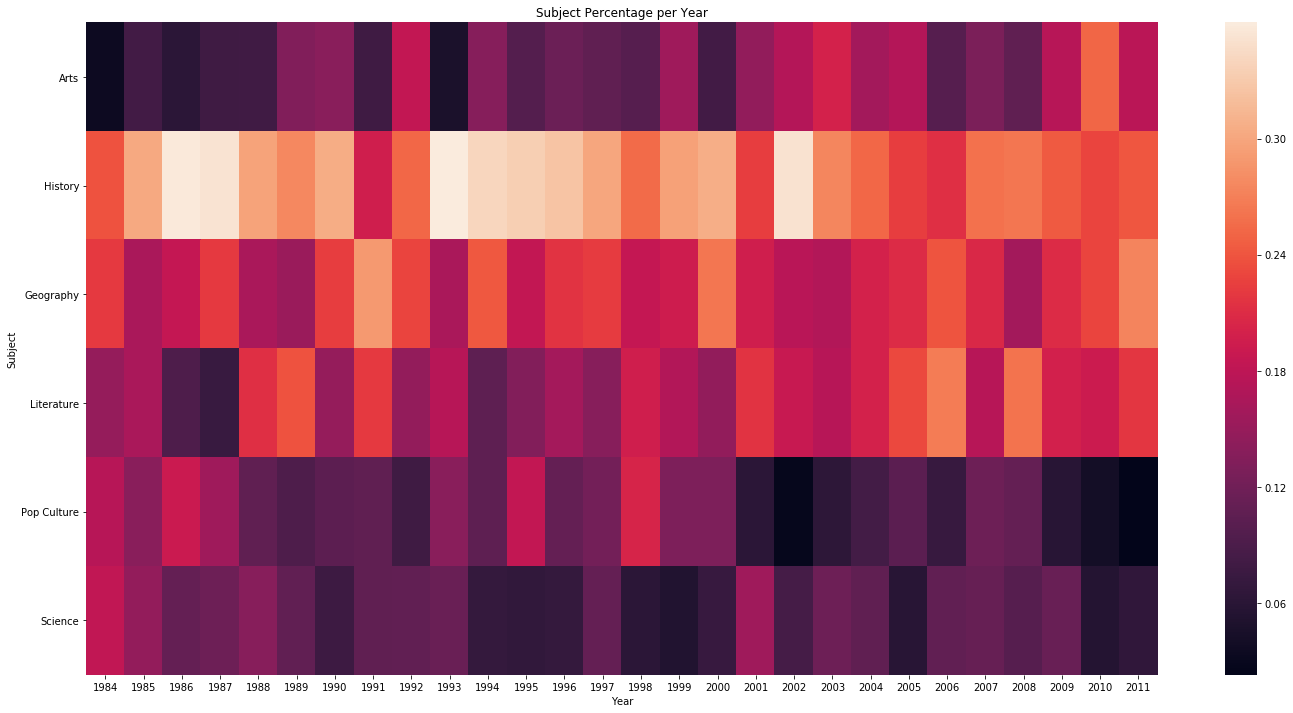

In [152]:
# Figure 5
# A heatmap that shows the percentage of of questions/categories belonging to a subject per year.

plt.figure(figsize=(24,12))
subjectsHeat = sns.heatmap(subjectsByYear, annot=False, fmt="f")

subjectsHeat.set_xticklabels(range(minYear, maxYear+1))
subjectsHeat.set_yticklabels(subjectList, rotation=0)
subjectsHeat.set_xlabel('Year')
subjectsHeat.set_ylabel('Subject')
subjectsHeat.set_title('Subject Percentage per Year')
plt.show()

After assigning a overarching subject to the different Jeopardy! categories, we created another heatmap that shows the percentage of questions belonging to a subject per year. The map shows that year after year, history is a very popular subject in Jeopardy!, often occupying roughly a third of questions asked each game. From figures 3 and 4, we observed a drastic change in the year 1997, but this figure does not share that trend. This could mean that when new writers come into the Jeopardy! question writing team, they still try to maintain a rough ratio of questions in each of these subjects.


## Rising Subjects

From the heat map we created above, we noticed that the frequency of geography questions was experiencing a growing trend. Using data from the most recent five years, we will be measuring the 'rise factor' for each subject, which quantifies the change in a subject's proportion of observations over time. The rise factors show which subjects are becoming more common and which subjects are becoming less common.

In [59]:
geographyIndex = subjectList.index('Geography')
print("Percentage of Geography questions in each year for the last 5 years")
geographyLastFiveYears = subjectsByYear[geographyIndex][-5:]
for i in range(0, len(geographyLastFiveYears)):
    print(str(2007+i) + ': ' + ('%.2f' % (geographyLastFiveYears[i]*100)) + '%')


Percentage of Geography questions in each year for the last 5 years
2007: 20.66%
2008: 15.98%
2009: 20.96%
2010: 22.96%
2011: 27.39%


Now we want to calculate a measure of each subject's rise/fall in the last 5 years. We will be taking the differences in frequency between years, summing this up, and dividing by the number of years we are analyzing, which is five years. The most recent years' differences will be weighed more in the summation.

In [73]:
def riseFactor(lastFiveYears):
    assert len(lastFiveYears) == 5
    sumWeightedDifferences = 0.0
    for i in range(4,0,-1):
        sumWeightedDifferences += (i * 0.1) * (lastFiveYears[i]-lastFiveYears[i-1])
        
    return sumWeightedDifferences/float(5)

In [74]:
results = []
for i in range(0, len(subjectsByYear)):
    subjectPercentByYear = subjectsByYear[i]
    lastFiveYears = subjectPercentByYear[-5:]
    subjectRiseFactor = (subjectList[i], riseFactor(lastFiveYears))
    results.append(subjectRiseFactor)
    
results.sort(key=lambda tup: tup[1], reverse=True)

for result in results:
    print(result[0] + " rise factor: " + str(result[1]))

Geography rise factor: 0.005800385828720657
Arts rise factor: 0.0009982304121799186
Literature rise factor: 0.0008982733732234412
History rise factor: -0.0006476313436039636
Science rise factor: -0.002323496914231622
Pop Culture rise factor: -0.004725761356288432


How to interpret: The number of geography questions are estimated to increase 0.058% from the year before, while questions relating to pop culture are estimated to decrease 0.047% each year from the year before.

## Consistent Subjects

We also want to calculate, on average, how much more or less did a subject appear than the expected frequency, which is a percentage, assuming that all subjects appeared equally on the show. We will be calling this computation the consistent performance factor. This time, we used the data from the entire lifetime of the show.


In [75]:
historyIndex = subjectList.index('History')
years = [1984, 1989, 1994, 1999, 2004, 2009]
print("Percentage of Geography questions in different years")
geographyLastFiveYears = subjectsByYear[historyIndex]
for i in range(0, len(years)):
    print(str(years[i]) + ': ' + ('%.2f' % (geographyLastFiveYears[years[i]-minYear]*100)) + '%')


Percentage of History questions in different years
1984: 23.83%
1989: 27.62%
1994: 34.04%
1999: 29.66%
2004: 25.22%
2009: 24.36%


In [76]:
def consistentFactor(means, subjectIndex):
    consistency = 0.0
    subjectPercentages = subjectsByYear[subjectIndex]
    for i in range(0, len(means)):
        consistency += (subjectPercentages[i]-means[i])
    return consistency/float(len(means))

In [77]:
consistencies = []
means = np.array(subjectsByYear).mean(axis = 0)
for i in range(0, len(subjectList)):
    consistency = (subjectList[i], consistentFactor(means, i))
    consistencies.append(consistency)
    
consistencies.sort(key=lambda tup: tup[1], reverse=True)

for consistency in consistencies:
    print(consistency[0] + " consistent performance factor: " + str(consistency[1]))

History consistent performance factor: 0.114593885479
Geography consistent performance factor: 0.0402480066132
Literature consistent performance factor: 0.0117152085564
Arts consistent performance factor: -0.0415718134543
Pop Culture consistent performance factor: -0.0581438220105
Science consistent performance factor: -0.0668414651839


How to interpret: The expected frequency of our six subjects, assuming that they are all appear equally on the show, is 16.67%. We found that History occurs about 11.46% more times than this expected frequency, while Science occurs 0.067% less.

## Subject Percentage Prediction

Now we will use linear regression to fit a model to our data. Based on lifetime data (our entire dataset as opposed to just five years), we can use linear models to predict the percentage frequencies of each subject for the next five years. 


In [82]:
dfSubjectsByYear.head()

,year,Arts,History,Geography,Literature,Pop Culture,Science
0,1984,0.034043,0.238298,0.221277,0.148936,0.174468,0.182979
1,1985,0.081967,0.303279,0.163934,0.163934,0.139344,0.147541
2,1986,0.061728,0.358025,0.185185,0.092593,0.191358,0.111111
3,1987,0.078431,0.352941,0.220588,0.073529,0.156863,0.117647
4,1988,0.079787,0.297872,0.164894,0.212766,0.106383,0.138298


In [83]:
subjectModels = {}
for subject in subjectList:
    subjectModels[subject] = np.polyfit(dfSubjectsByYear['year'], dfSubjectsByYear[subject], 1)
    
subjectModels

{'Arts': array([  4.00107895e-03,  -7.86706034e+00]),
 'Geography': array([  7.33402378e-04,  -1.25805658e+00]),
 'History': array([ -2.60019517e-03,   5.47515040e+00]),
 'Literature': array([  3.01245561e-03,  -5.83899822e+00]),
 'Pop Culture': array([ -3.45107509e-03,   7.00204533e+00]),
 'Science': array([ -1.69566669e-03,   3.48691941e+00])}

In [84]:
def predictPercentage(subject, year):
    a0 = subjectModels[subject][0]
    a1 = subjectModels[subject][1]
    predictedPercentage = (a0 * year) + a1
    return predictedPercentage

In [85]:
nextFiveYears = range(maxYear + 1, maxYear + 1 + 5)
for subject in subjectList:
    print("Predictions for Subject: " + subject)
    for year in nextFiveYears:
        print(str(year) + ":\t" + str(predictPercentage(subject, year)*100) + "%")
        
    print()

Predictions for Subject: Arts
2012:	18.3110497941%
2013:	18.7111576888%
2014:	19.1112655835%
2015:	19.5113734781%
2016:	19.9114813728%

Predictions for Subject: History
2012:	24.3557722213%
2013:	24.0957527046%
2014:	23.8357331878%
2015:	23.575713671%
2016:	23.3156941542%

Predictions for Subject: Geography
2012:	21.7549007763%
2013:	21.8282410141%
2014:	21.9015812519%
2015:	21.9749214897%
2016:	22.0482617276%

Predictions for Subject: Literature
2012:	22.2062481638%
2013:	22.5074937253%
2014:	22.8087392867%
2015:	23.1099848482%
2016:	23.4112304097%

Predictions for Subject: Pop Culture
2012:	5.84822559115%
2013:	5.50311808257%
2014:	5.15801057398%
2015:	4.8129030654%
2016:	4.46779555682%

Predictions for Subject: Science
2012:	7.52380345334%
2013:	7.35423678472%
2014:	7.1846701161%
2015:	7.01510344749%
2016:	6.84553677887%



We can compare our linear model's predictions with the rise factors found in "Rising Subjects" a few sections before. In this model, the number of geography questions are estimated to increase around 0.07% each year, which is similar to the 0.058% rising factor we calculated for geography earlier. For science, the linear regression model estimates that the number of science questions are decreasing around 0.17% each year, whereas the rise factor we computed was 0.2%, which is fairly close as well. 

The linear models seem to exaggerate the differences in frequency each year more than the rise factor. However, the linear regression model is based on data that covers the course of the entire show, so the linear models might be more accurate in overall representation of Jeopardy! data. On the other hand, the rise factor is based on more recent data and accounts for the weights implied in more relevant data, so it can also be useful as well. 


## Answer Analysis

Similar to the category-subject analysis we computed above, we will be performing analysis with the most common answers in Jeopardy!. Below, we took the top 50 most common answers and manually categorized each one. Ultimately, we categorized all the answers with three subjects: literature, person, and place.

After assigning each answer to a subject, we can estimate how frequently each answer appears in Jeopardy! questions per year. We will use a heat map to show this; x-axis being the year and y-axis being the subject, each tile will be color coded by the frequency of the subject. 


In [93]:
answerTypes = ['literature', 'person', 'place']

In [94]:
answerTop

china                215
australia            214
japan                196
chicago              196
france               191
india                184
california           180
canada               175
spain                171
mexico               163
alaska               161
italy                160
hawaii               157
texas                152
paris                149
germany              147
russia               141
florida              140
south africa         139
ireland              135
brazil               133
london               132
george washington    130
sweden               129
new orleans          128
greece               125
ronald reagan        125
thomas jefferson     123
abraham lincoln      123
egypt                122
new york             121
georgia              119
boston               118
san francisco        117
switzerland          115
norway               111
new zealand          110
napoleon             109
philadelphia         109
virginia             108


In [95]:
answers = [
    'china',
    'australia',
    'japan',
    'chicago',
    'france',
    'india',
    'california',
    'canada',
    'spain',
    'mexico',
    'alaska',
    'italy',
    'hawaii',
    'texas',
    'paris',
    'germany',
    'russia',
    'florida',
    'south africa',
    'ireland',
    'brazil',
    'london',
    'george washington',
    'sweden',
    'new orleans',
    'ronald reagan',
    'greece',
    'thomas jefferson',
    'abraham lincoln',
    'egypt',
    'new york',
    'georgia',
    'boston',
    'san francisco',
    'switzerland',
    'norway',
    'new zealand',
    'philadelphia',
    'napoleon',
    'denmark',
    'virginia',
    'richard nixon',
    'maine',
    'cuba',
    'massachusetts',
    'colorado',
    'scotland',
    'louisiana',
    'rome',
    'hamlet'
]

types = [
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'person',
    'place',
    'place',
    'person',
    'place',
    'person',
    'person',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'person',
    'place',
    'place',
    'person',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'literature'
]

for answerType in types:
    assert answerType in answerTypes
    
answerToType = dict(zip(answers, types))

In [96]:
def assignAnswerType(answer):
    return answerToType[answer]

pd.options.mode.chained_assignment = None  # default='warn'
dfAnswerAndType = dfClean[dfClean['answer'].isin(list(answerToType.keys()))]
dfAnswerAndType['type'] = dfAnswerAndType['answer'].apply(assignAnswerType)
display(dfAnswerAndType.sample(10))

,year,category,answer,type
141654,1990,STATE FLAGS,hawaii,place
31645,2005,BE A POTATO HEAD,ireland,place
175536,1998,AFRICAN AMERICANS,chicago,place
161207,2004,FRAIDY CAT,france,place
64825,2011,SHIP NAMES,maine,place
186717,1995,WORLD GEOGRAPHY,switzerland,place
6319,1999,Y1K,japan,place
94912,2004,SPAM,hawaii,place
82901,1996,CONTINENTAL CONGRESSMEN,george washington,person
139851,2000,BOOKS ABOUT PRESIDENTS,richard nixon,person


In [97]:
answerObservationsByYear = {}
for year in range(minYear, maxYear + 1):
    count = len(dfAnswerAndType[dfAnswerAndType['year']==str(year)])
    answerObservationsByYear.update({str(year) : count})

In [98]:
answerTypesByYear = []
dfAnswerTypesByYear = pd.DataFrame()
dfAnswerTypesByYear['year'] = range(minYear, maxYear + 1)

for i in range(0, len(answerTypes)):
    answerType = dfAnswerAndType[dfAnswerAndType['type']==answerTypes[i]]
    countsForType = []
    for year in range(minYear, maxYear+1):
        yearType = answerType[answerType['year']==str(year)]
        countsForType.append(float(len(yearType))/float(answerObservationsByYear[str(year)]))

    answerTypesByYear.append(countsForType)
    dfAnswerTypesByYear[answerTypes[i]] = countsForType
    
display(dfAnswerTypesByYear)

,year,literature,person,place
0,1984,0.000000,0.166667,0.833333
1,1985,0.000000,0.130435,0.869565
2,1986,0.022222,0.177778,0.800000
3,1987,0.000000,0.152174,0.847826
4,1988,0.000000,0.100000,0.900000
5,1989,0.000000,0.154930,0.845070
6,1990,0.019868,0.145695,0.834437
7,1991,0.023810,0.095238,0.880952
8,1992,0.000000,0.090909,0.909091
9,1993,0.000000,0.108434,0.891566


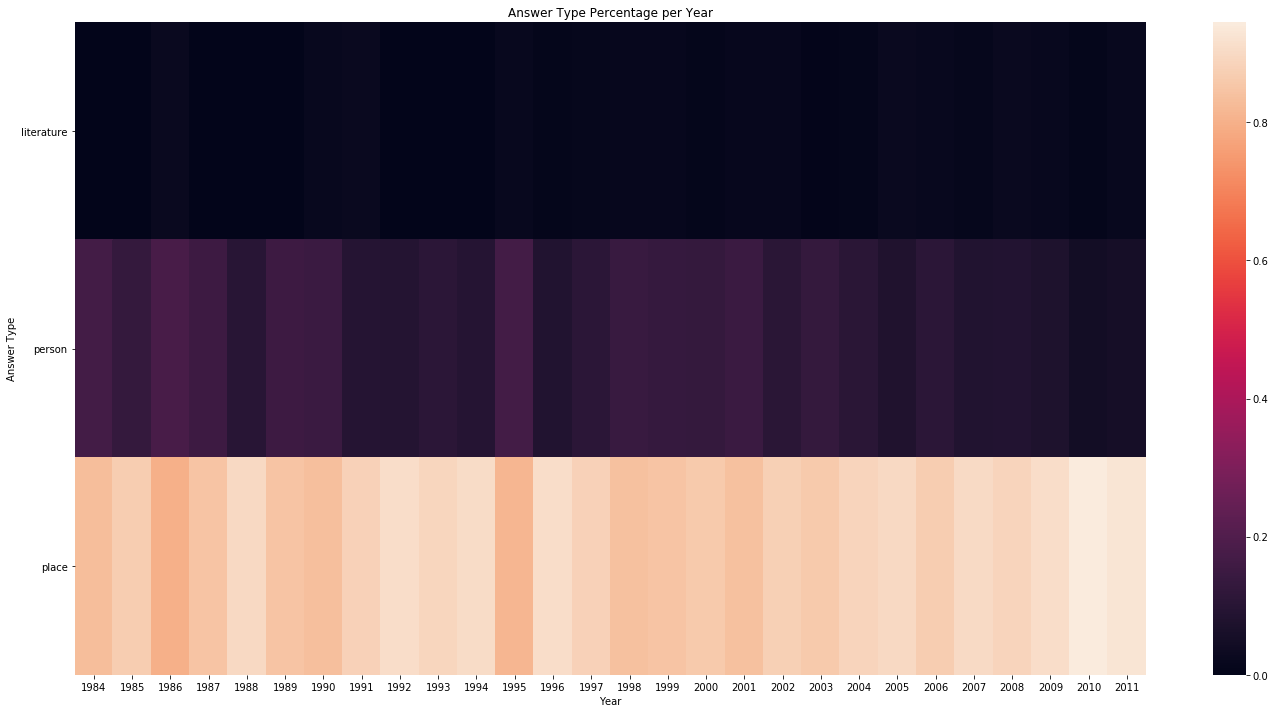

In [99]:
# Figure 6
# A heat map showing the percentage of answers belonging to the three different classifiers: places, people, literature

plt.figure(figsize=(24,12))
answerTypeHeat = sns.heatmap(answerTypesByYear, annot=False, fmt="f")

answerTypeHeat.set_xticklabels(range(minYear, maxYear+1))
answerTypeHeat.set_yticklabels(answerTypes, rotation=0)
answerTypeHeat.set_xlabel('Year')
answerTypeHeat.set_ylabel('Answer Type')
answerTypeHeat.set_title('Answer Type Percentage per Year')
plt.show()

Similar to process we used to add a subject to the categories, we decided to add a classifier to the answers as well. Most of the top 50 answers came as a person, a place, or a title of a literary work. The heatmao we created using these classifiers showed that the top 50 answers were overwhelming places. This however, does not not necessarily indicate that the answers are geographical in nature. Places can be related to history or the arts, or any other subject/category. Additionally, this heatmap also seems resistant to the changes that were made in 1997.



## Rising Answer Types

From the heat map we created above, we noticed that most answers were names of places (cities, countries, etc). Similar to before, using the most recent five years of data, we will find the 'rise factor' for place, literature, and person.

Rise factor can be thought of as the growth rate of a category/answer, as in will there be more or less of this in the future.

In [100]:
placeIndex = answerTypes.index('place')
print("Percentage of Place answers in each year for the last 5 years")
placeLastFiveYears = answerTypesByYear[placeIndex][-5:]
for i in range(0, len(placeLastFiveYears)):
    print(str(2007+i) + ': ' + ('%.2f' % (placeLastFiveYears[i]*100)) + '%')


Percentage of Place answers in each year for the last 5 years
2007: 90.24%
2008: 88.78%
2009: 90.77%
2010: 94.44%
2011: 92.90%


In [101]:
risingAnswers = []
for i in range(0, len(answerTypesByYear)):
    typePercentByYear = answerTypesByYear[i]
    lastFiveYears = typePercentByYear[-5:]
    typeRiseFactor = (answerTypes[i], riseFactor(lastFiveYears))
    risingAnswers.append(typeRiseFactor)
    
risingAnswers.sort(key=lambda tup: tup[1], reverse=True)

for answer in risingAnswers:
    print(answer[0] + " rise factor:\t" + str(answer[1]))
    

place rise factor:	0.001470138652249451
literature rise factor:	0.00021354452391582107
person rise factor:	-0.0016836831761652704


## Consistent Answer Types

Again, we will be computing the consistent performance factor for our answers data for place, person, and literature. Since there are only three subjects, the expected frequency of these subjects, assuming that they all appear equally, is 33.33%.

Consistent Performance Factor can be thought of how often is this category/question appearing in compairison to how often we think it should. The expected value should be a subject should appear about 1/6 of the time (if there are 6 subjects with questions evenly spread among them)

In [112]:
placeIndex = answerTypes.index('place')
years = [1984, 1989, 1994, 1999, 2004, 2009]
print("Percentage of Place answers in different years")
placeByYears = answerTypesByYear[placeIndex]
for i in range(0, len(years)):
    print(str(years[i]) + ': ' + ('%.2f' % (placeByYears[years[i]-minYear]*100)) + '%')


Percentage of Place answers in different years
1984: 83.33%
1989: 84.51%
1994: 90.62%
1999: 84.77%
2004: 88.78%
2009: 90.77%


In [113]:
def consistentFactor(means, typeIndex):
    consistency = 0.0
    typePercentages = answerTypesByYear[typeIndex]
    for i in range(0, len(means)):
        consistency += (typePercentages[i]-means[i])
    return consistency/float(len(means))

In [114]:
consistencies = []
means = np.array(answerTypesByYear).mean(axis = 0)
for i in range(0, len(answerTypes)):
    consistency = (answerTypes[i], consistentFactor(means, i))
    consistencies.append(consistency)
    
consistencies.sort(key=lambda tup: tup[1], reverse=True)

for consistency in consistencies:
    print(consistency[0] + " consistent performance factor: " + str(consistency[1]))

place consistent performance factor: 0.540482769558
person consistent performance factor: -0.218949436664
literature consistent performance factor: -0.321533332894


How to interpret: Place answers occur 54% greater more frequently than the expected frequency (33%). 

## Answer Type Percentage Prediction

Again, we will use linear regression to fit a model to our data. Based on lifetime data, we can use linear models in order to predict the percentage frequencies of each subject for the next five years. 


In [116]:
dfAnswerTypesByYear.head()

,year,literature,person,place
0,1984,0.000000,0.166667,0.833333
1,1985,0.000000,0.130435,0.869565
2,1986,0.022222,0.177778,0.800000
3,1987,0.000000,0.152174,0.847826
4,1988,0.000000,0.100000,0.900000


In [117]:
typeModels = {}
for answerType in answerTypes:
    typeModels[answerType] = np.polyfit(dfAnswerTypesByYear['year'], dfAnswerTypesByYear[answerType], 1)

typeModels

{'literature': array([  5.38609202e-04,  -1.06407188e+00]),
 'person': array([ -2.76520197e-03,   5.63787483e+00]),
 'place': array([  2.22659277e-03,  -3.57380295e+00])}

In [118]:
def predictTypePercentage(answerType, year):
    a0 = typeModels[answerType][0]
    a1 = typeModels[answerType][1]
    predictedPercentage = (a0 * year) + a1
    return predictedPercentage

In [120]:
for answerType in answerTypes:
    print("Predictions for Answers: " + answerType)
    for year in nextFiveYears:
        print(str(year) + ":\t" + str(predictTypePercentage(answerType, year)*100) + "%")
        
    print()

Predictions for Answers: literature
2012:	1.96098338619%
2013:	2.01484430635%
2014:	2.0687052265%
2015:	2.12256614666%
2016:	2.17642706682%

Predictions for Answers: person
2012:	7.42884681465%
2013:	7.15232661794%
2014:	6.87580642123%
2015:	6.59928622452%
2016:	6.32276602781%

Predictions for Answers: place
2012:	90.6101697992%
2013:	90.8328290757%
2014:	91.0554883523%
2015:	91.2781476288%
2016:	91.5008069054%



# Privacy/Ethics Considerations

The data we used raises little to no ethics or privacy considerations.

We had full permission to use the data as noted on the original Reddit thread, so long as we give the original poster credit and let them know of our project.

In terms of bias in collection of our data, there is a slight chronological bias to our data set. The person who collected the data had only about 85% of total questions at the time of their work. This meant that the dataset did not contain games from the last previous two years to the date of the original thread post. This could affect the data as any answers from those years will not be reflected in our observation. We hope this will be a minor issue as the game has had no major redesigns and the questions have not changed in wording nor relative difficulty.

In terms of privacy considerations, none of the data collected is linked personally to anyone. There are no names, birthdates, hometowns or any identifying points of data in the CSV file. However, the CSV files does include show air dates, which would mean that if a person were so inclined, they could figure out which people were on the show on a particular day. This is information that is already public on the Jeopardy Archive site.

# Conclusions and Discussion

From our data it would not be a stretch to say that there is a definitive way to study for Jeopardy and that would be to study geography/places in relation to the top subjects: history and literature. However, our answer to the research question, “is there an optimal strategy to preparing to be a contestant on Jeopardy!?” is that there is not such a strategy.

Although our analyses show that typically, history is the most common subject and places are the most common type of answer, our observations and analyses have limitations in that, only the top 50 answers/categories of the game. To put that in perspective, there are over 85,000 unique categories and 180,000 unique answers. With the top 50 categories we barely get 25% of all categories and with the top 50 answers we get even less that, about 10%. But we still stick to the top 50 because we believe those answers and categories are a decent representation of what Jeopardy questions and answers are. In addition, running our analyses on every single category and answer would not be feasible nor practical. Our data is so text rich and diverse that it would take a lot of semantic tagging of answers and categories in order to do analysis similar to what we did in this notebook. If we were to take further steps with this project, it would be to determine a method in which we can use all of our data and to collect the data from the most recent years, as this dataset only has data until 2012

Our data analysis consisted of several processes: interpreting the different figures, analyzing changes in popularity/commonality of the different subjects, attempting to predict how much of each subject would appear in a single game of Jeopardy!, and then repeating the process for the answers. 

These are our findings:

Questions about arts, geography and literature are on the rise, while questions about history, pop culture and science are on the decline. 
    - Geography rise factor: 0.005800385828720657
    - Arts rise factor: 0.0009982304121799186
    - Literature rise factor: 0.0008982733732234412
    - History rise factor: -0.0006476313436039636
    - Science rise factor: -0.002323496914231622
    - Pop Culture rise factor: -0.004725761356288432
	(see subject rise factor methods for calculations)
    
Questions about history, geography, and literature tend to appear more often than one would expect
    - History consistent performance factor: 0.114593885479
    - Geography consistent performance factor: 0.0402480066132
    - Literature consistent performance factor: 0.0117152085564
    - Arts consistent performance factor: -0.0415718134543
    - Pop Culture consistent performance factor: -0.0581438220105
    - Science consistent performance factor: -0.0668414651839
    (see subject consistency methods for calculations)
    
Questions about history, geography, and literature should appear in roughly equal amounts in a game and will account for about 60-70% of questions in a game (see subject prediction methods)
    - In recent years history questions account for around 23%, geography questions account for 22% and literature 
      questions account for 23, additionally arts questions take up almost another 20%

Answers are most likely to be places (see answer consistency methods and answer prediction methods
    - The percentage of answers classified as a place have been a little bit over 90% for the last 5 years

As time continues, and more questions are added, our analyses will become less accurate as they would dilute the strength/weight of the top 50 answers/categories on our calculations. So, even though we are going to conclude with there is no optimal strategy, we still have some suggestions that may help. Using our rise factor calculations for answers/categories, it may prove beneficial to study categories/answers that are on the rise. Since our data stops in 2012, at that time, studying history, geography, literature, and even the arts would have proven beneficial as we predicted those categories to be 80% of questions in a game. These are broad subjects to study, but you can add more focus by looking at the most common answers in those categories/subjects and paying more attention to those.

There are already existing tools made by former contestants that people use to prepare for being on the show. These tools often include randomly selecting questions from the J! archive or allowing people to select categories they feel they should work on. However, should our analysis prove true, it could help future contestants prepare in a more focused way by possibly anticipating what the categories/questions may be.

Overall, the diversity of categories and answers in Jeopardy! Are good evidence to support a claim that preparing for Jeopardy is difficult and it requires a mastery of knowledge and recall in many different areas of study.
